# Emotion Prediction through Eye Tracking Data

Eye tracking data from virtual reality or mixed reality headsets can provide plethora of information that can potentially deduce the emotion of the user, which could be used to enhance immersion within a VR/MR application given that it follows strict ethical guidelines. Within the domain of machine learning, this implies that eye tracking data can be used as a part of a classification task. In fact, the dataset used within this project comes from a study ([Tabbaa et. al.](#References)) done with various 360 virtual environment videos to detect emotional response while simultaneously measuring eye tracking data, ECG (Electrocardiogram) and GSR (Galvanic Skin Reponse). The dataset is published on Kaggle by the same research group (https://www.kaggle.com/datasets/lumaatabbaa/vr-eyes-emotions-dataset-vreed). It is divided into three csv files for eye tracking, ECG and GSR, and each includes rows of experiments along with the corresponding emotional response as derived from the Circumplex Model of Affects. The paper shows preliminary machine learning analysis using Support Vector Machines in prediction of emotional responses given eye tracking only, ECG only, GSR only, or aggregated dataset containing all features. The purpose of this project is to expand upon this prelimnary analysis to include various other classification models, such as logistic regression and ensemble methods, to see if it is possible to improve the reported accuracies.



In [214]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [215]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA



### Check experiment ordering

The data from the experiments were divided into three separate csv files for Eye Tracking, ECG and GSR. Thus, we need to make sure that the rows in each file correspond with each other. The feature 'Quad_Cat' refers to the derived emotional response from questionnaires at the end of each experiment. Each dataset contains the same feature, but we will do a quick check to see if they are indeed in the same order. 


In [216]:
# Import datasets
df_ET = pd.read_csv('./data/EyeTracking.csv')
df_ECG = pd.read_csv('./data/ECG.csv')
df_GSR = pd.read_csv('./data/GSR.csv')
labels = df_ET['Quad_Cat']

# The datasets are aligned such that corresponding rows in each dataset refer to the same experimental instance
df_labels = pd.concat([df_ET['Quad_Cat'], df_ECG['Quad_Cat'], df_GSR['Quad_Cat']], axis = 1)

In [217]:
# check that labels in each dataset correspond with each other
df_labels.corr()

,Quad_Cat,Quad_Cat,Quad_Cat
Quad_Cat,1.0,1.0,1.0
Quad_Cat,1.0,1.0,1.0
Quad_Cat,1.0,1.0,1.0


### Data Description

Each dataset contains 312 rows for each instance of experiment. Eye tracking data contains 49 non-label features, each being a numerical data. They are mostly floats, but some are integers such as the number of fixations. Similarly, ECG and GSR contain numerical data with 18 and 8 non-label features, respectively. 


In [218]:
df_ET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Quad_Cat                 312 non-null    int64  
 1   Num_of_Fixations         312 non-null    float64
 2   Mean_Fixation_Duration   312 non-null    float64
 3   SD_Fixation_Duration     312 non-null    float64
 4   Skew_Fixation_Duration   312 non-null    float64
 5   Max_Fixation_Duration    312 non-null    int64  
 6   First_Fixation_Duration  312 non-null    int64  
 7   Num_of_Saccade           312 non-null    float64
 8   Mean_Saccade_Duration    312 non-null    float64
 9   SD_Saccade_Duration      312 non-null    float64
 10  Skew_Saccade_Duration    312 non-null    float64
 11  Max_Saccade_Duration     312 non-null    int64  
 12  Mean_Saccade_Amplitude   312 non-null    float64
 13  SD_Saccade_Amplitude     312 non-null    float64
 14  Skew_Saccade_Amplitude   3

In [219]:
df_ECG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Quad_Cat    312 non-null    int64  
 1   Mean        312 non-null    float64
 2   Min         312 non-null    float64
 3   Max         312 non-null    float64
 4   MeanRR      312 non-null    int64  
 5   MedianRR    312 non-null    float64
 6   MinRR       312 non-null    int64  
 7   MaxRR       312 non-null    int64  
 8   LF          312 non-null    float64
 9   HF          312 non-null    float64
 10  VLF         312 non-null    float64
 11  Ibi         312 non-null    float64
 12  Bpm         312 non-null    float64
 13  Sdnn        312 non-null    float64
 14  Sdsd        312 non-null    float64
 15  Rmssd       312 non-null    float64
 16  Pnn50       312 non-null    float64
 17  pnn20       312 non-null    float64
 18  Pnn50pnn20  312 non-null    float64
dtypes: float64(15), int64(4)
memo

In [220]:
df_GSR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Quad_Cat           312 non-null    int64  
 1   Mean               312 non-null    float64
 2   SD                 312 non-null    float64
 3   Variance           312 non-null    float64
 4   Minimum            312 non-null    float64
 5   Maximum            312 non-null    float64
 6   Number of Peaks    312 non-null    float64
 7   Number of Valleys  312 non-null    float64
 8   Ratio              312 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 22.1 KB


### Dealing with Outliers

Below are box plots for each feature in each dataset

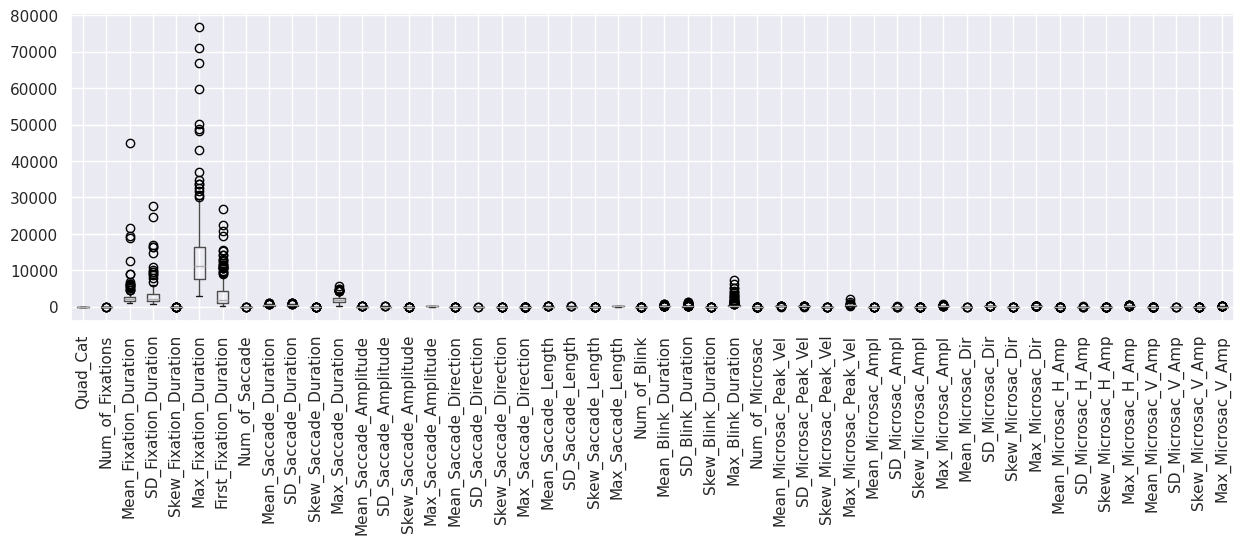

In [221]:
plt.figure(figsize=(15, 4))
df_ET[df_ET.columns].boxplot()
plt.xticks(rotation=90)
plt.show()

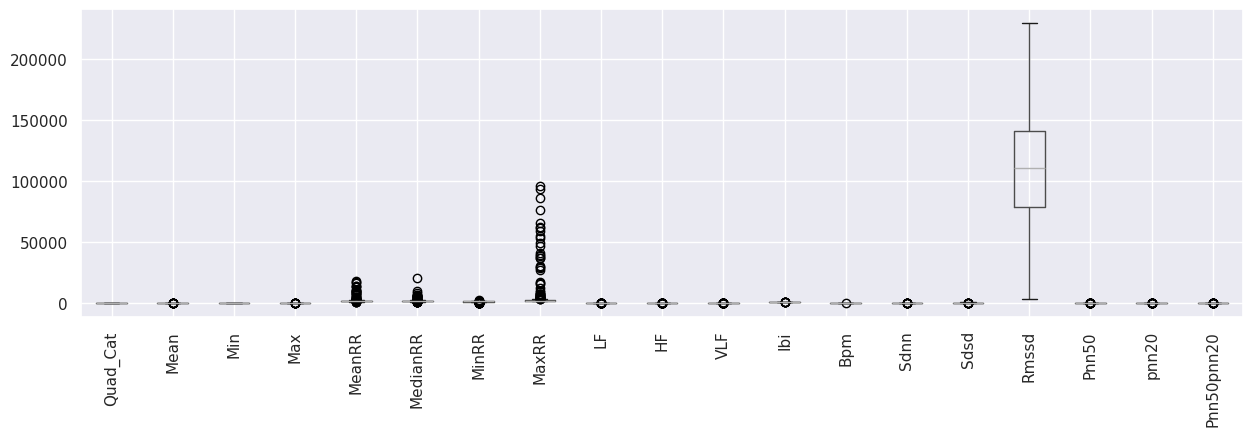

In [222]:
plt.figure(figsize=(15, 4))
df_ECG[df_ECG.columns].boxplot()
plt.xticks(rotation=90)
plt.show()

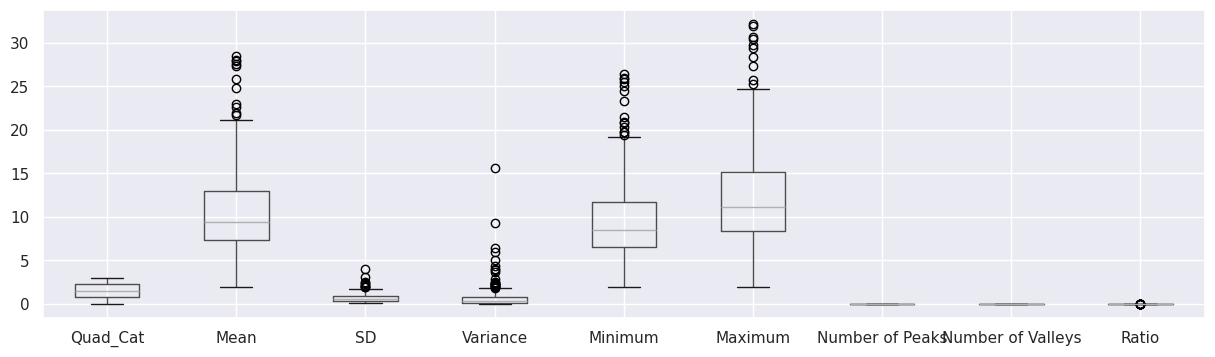

In [223]:
plt.figure(figsize=(15, 4))
df_GSR[df_GSR.columns].boxplot()
plt.show()

<br>
As we can see from the plots, there is an abundant amount of outliers in each feature. Even after taking into consideration overlaps among features, we would be left with too many unique outliers that need to be removed given the sparsity of our dataset. For instance, for Mean Fixation Duration in Eye Tracking data, we already have 18 outliers out of a total of 312 data points.


In [224]:
Q1 = df_ET['Mean_Fixation_Duration'].quantile(0.25)
Q3 = df_ET['Mean_Fixation_Duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_ET[(df_ET['Mean_Fixation_Duration'] < lower_bound) | (df_ET['Mean_Fixation_Duration'] > upper_bound)]
outliers

,Quad_Cat,Num_of_Fixations,Mean_Fixation_Duration,SD_Fixation_Duration,Skew_Fixation_Duration,Max_Fixation_Duration,First_Fixation_Duration,Num_of_Saccade,Mean_Saccade_Duration,SD_Saccade_Duration,...,Skew_Microsac_Dir,Max_Microsac_Dir,Mean_Microsac_H_Amp,SD_Microsac_H_Amp,Skew_Microsac_H_Amp,Max_Microsac_H_Amp,Mean_Microsac_V_Amp,SD_Microsac_V_Amp,Skew_Microsac_V_Amp,Max_Microsac_V_Amp
52,1,0.022222,44860.250000,27628.578390,-0.122971,76825,9774,0.016667,214.666667,224.609290,...,0.005445,179.384870,0.318165,9.567190,2.495247,50.968631,0.372922,2.040257,2.620585,8.804223
53,2,0.052326,18780.555560,16824.371650,0.623588,50243,26781,0.046512,376.750000,375.782517,...,0.283583,179.074328,-2.214138,18.686274,0.903303,58.515132,0.546596,7.035427,3.273806,35.186786
54,2,0.045977,21676.500000,16263.078320,0.025863,43094,11445,0.040230,99.000000,72.711760,...,0.168704,179.589941,1.014925,6.769902,0.179277,18.381401,-0.021408,1.814091,-0.405308,6.089341
55,2,0.051724,19383.000000,24668.233410,1.047052,66889,8012,0.043103,63.600000,28.147824,...,0.022184,178.884463,1.795290,7.863677,0.744910,32.231955,0.045213,2.929176,1.392019,13.628654
56,0,0.079470,12416.666670,14711.995770,1.339510,48198,1511,0.072848,198.636364,157.334213,...,-0.300102,179.114656,1.423353,8.191393,0.454092,29.058429,1.423999,4.173095,2.865332,20.198538
57,1,0.204969,4592.090909,4567.372544,1.987966,22337,8579,0.198758,323.875000,315.901960,...,-0.009501,179.743193,-0.986850,25.581857,1.899872,143.842648,0.599987,4.629217,2.396664,22.551352
59,3,0.106667,9080.125000,5891.942426,-0.086725,16512,15190,0.093333,388.000000,433.975806,...,-0.379646,179.296144,-3.850279,8.756789,-0.721703,10.149288,2.484247,7.780917,2.670543,30.370499
70,3,0.137500,6801.545455,9439.288420,1.601494,31872,11445,0.125000,532.800000,293.168817,...,0.161146,179.407479,-0.931264,22.047066,1.063781,84.697439,-0.169885,4.805522,0.496775,20.203617
75,3,0.165289,5800.350000,8932.394270,2.246337,36914,1805,0.157025,269.842105,292.473600,...,-0.083999,179.906081,1.737555,14.455060,1.874533,59.364479,0.537899,6.649766,2.523345,38.193825
111,3,0.157025,6104.947368,16404.093650,3.284097,71116,1666,0.157025,273.684211,531.042063,...,-0.028215,179.647350,-4.218268,23.025636,-5.568769,14.908442,-1.532577,12.881655,-6.748401,6.950295


As a response to this, I have decided to use robust scaling to reduce the effects of outliers rather removing them.

Next we will drop the label feature in each dataset and store it as a separate series. Then we can combine each dataset into an aggregate form.

In [225]:
# drop labels in each data set
df_ET = df_ET.drop(columns=['Quad_Cat'])
df_ECG = df_ECG.drop(columns=['Quad_Cat'])
df_GSR = df_GSR.drop(columns=['Quad_Cat'])

# add prefix to feature names so that they are distinguishable when combining them into aggregate dataset
df_ET = df_ET.add_prefix('ET_')
df_ECG = df_ECG.add_prefix('ECG_')
df_GSR = df_GSR.add_prefix('GSR_')

In [226]:
df_COMBINED = pd.concat([df_ET, df_ECG, df_GSR], axis = 1)

### NaN's
Before we scale the features, we need to look for null values and decide to remove or impute them. Similar to the decision to use robust scaling rather than removing the outliers, we will mean impute the missing values.

In [227]:
# there are 96 total null values
df_COMBINED.isna().sum().sum()

np.int64(96)

In [228]:
from sklearn.preprocessing import RobustScaler

# fill nan's with mean values
df_COMBINED = df_COMBINED.fillna(df_COMBINED.mean())

In [229]:
# robust scale each feature
df_COMBINED = pd.DataFrame(RobustScaler().fit_transform(df_COMBINED), columns=df_COMBINED.columns)

In [230]:
df_COMBINED.head()

,ET_Num_of_Fixations,ET_Mean_Fixation_Duration,ET_SD_Fixation_Duration,ET_Skew_Fixation_Duration,ET_Max_Fixation_Duration,ET_First_Fixation_Duration,ET_Num_of_Saccade,ET_Mean_Saccade_Duration,ET_SD_Saccade_Duration,ET_Skew_Saccade_Duration,...,ECG_pnn20,ECG_Pnn50pnn20,GSR_Mean,GSR_SD,GSR_Variance,GSR_Minimum,GSR_Maximum,GSR_Number of Peaks,GSR_Number of Valleys,GSR_Ratio
0,1.158568,-0.728283,-0.641530,-0.000383,-0.563783,-0.053123,1.153422,0.432086,0.566543,0.184784,...,0.021621,0.580503,-1.041589,-0.628539,-0.362887,-1.009833,-1.057684,-0.491642,-0.541712,-0.475551
1,0.290176,-0.230420,-0.172042,0.250877,-0.150357,-0.405329,0.251295,0.194501,0.133285,-0.874991,...,-0.045825,0.630260,-0.685230,0.227805,0.234838,-0.868363,-0.588589,0.176991,0.195016,0.559923
2,0.413675,-0.381689,-0.163850,-0.424315,-0.399819,-0.367964,0.353201,0.655158,0.621389,-0.131466,...,-0.357512,0.630260,-0.950564,0.015504,0.014238,-1.189784,-0.949661,0.365782,0.403034,1.280920
3,0.262659,-0.177530,0.277835,1.150116,0.424198,0.000162,0.235747,-0.026039,0.136014,0.307141,...,-0.732760,0.283858,-0.713612,0.610751,0.753476,-1.030056,-0.506598,0.381514,0.420368,0.582934
4,0.697130,-0.411811,-0.366765,-0.206782,-0.405148,-0.158720,0.673289,-0.220530,-0.207146,0.392964,...,0.128155,0.479667,-1.099753,-0.595952,-0.354358,-1.076721,-1.113154,-0.058997,-0.065005,-0.241611


In [231]:
labels

0      1
1      0
2      0
3      3
4      1
      ..
307    2
308    0
309    1
310    3
311    3
Name: Quad_Cat, Length: 312, dtype: int64

### Addressing multicollinearity

Because this project is mainly concerned with classification and the algorithms we will be using are robust against collinearity, there is not much justification to do thorough analysis of multicollinearity to drop some of the features. However, because of the large number of features present in our aggregate dataset, it would be preferred to drop some of the highly correlative features.

In [232]:
df_COMBINED.corr()

,ET_Num_of_Fixations,ET_Mean_Fixation_Duration,ET_SD_Fixation_Duration,ET_Skew_Fixation_Duration,ET_Max_Fixation_Duration,ET_First_Fixation_Duration,ET_Num_of_Saccade,ET_Mean_Saccade_Duration,ET_SD_Saccade_Duration,ET_Skew_Saccade_Duration,...,ECG_pnn20,ECG_Pnn50pnn20,GSR_Mean,GSR_SD,GSR_Variance,GSR_Minimum,GSR_Maximum,GSR_Number of Peaks,GSR_Number of Valleys,GSR_Ratio
ET_Num_of_Fixations,1.000000,-0.604457,-0.734658,0.172732,-0.718275,-0.410209,0.999119,0.310356,0.343761,0.190974,...,0.001587,0.057426,-0.031133,-0.082772,-0.046696,-0.013711,-0.047219,-0.074388,-0.073778,-0.062173
ET_Mean_Fixation_Duration,-0.604457,1.000000,0.886562,-0.279585,0.706204,0.358865,-0.602993,-0.230428,-0.255638,-0.208530,...,0.044787,0.030092,-0.061387,0.057892,0.019307,-0.069916,-0.040893,-0.053944,-0.051923,-0.038809
ET_SD_Fixation_Duration,-0.734658,0.886562,1.000000,-0.080770,0.918578,0.339606,-0.732574,-0.248090,-0.251009,-0.182559,...,0.029556,0.021072,-0.045730,0.066747,0.025560,-0.059350,-0.025205,-0.011441,-0.012723,-0.012616
ET_Skew_Fixation_Duration,0.172732,-0.279585,-0.080770,1.000000,0.244157,-0.181054,0.175485,0.173949,0.233899,0.148649,...,-0.084109,0.022980,0.080460,-0.008288,-0.012130,0.071840,0.063246,0.015385,0.012661,-0.082032
ET_Max_Fixation_Duration,-0.718275,0.706204,0.918578,0.244157,1.000000,0.283682,-0.714371,-0.228214,-0.198350,-0.101977,...,-0.005872,0.012087,-0.017325,0.062715,0.022004,-0.032797,-0.000485,-0.006487,-0.005771,-0.056692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSR_Minimum,-0.013711,-0.069916,-0.059350,0.071840,-0.032797,-0.025304,-0.016354,0.111894,0.068558,-0.001583,...,0.132205,-0.006347,0.982255,0.285223,0.109878,1.000000,0.943303,0.309728,0.281482,0.284999
GSR_Maximum,-0.047219,-0.040893,-0.025205,0.063246,-0.000485,0.020391,-0.048629,0.036852,-0.002272,0.022946,...,0.140694,0.023735,0.980993,0.573800,0.370272,0.943303,1.000000,0.378274,0.349991,0.329451
GSR_Number of Peaks,-0.074388,-0.053944,-0.011441,0.015385,-0.006487,0.089969,-0.081121,0.137264,0.103710,-0.064282,...,-0.043895,0.014925,0.368421,0.339429,0.250338,0.309728,0.378274,1.000000,0.985503,0.848455
GSR_Number of Valleys,-0.073778,-0.051923,-0.012723,0.012661,-0.005771,0.087127,-0.080180,0.128050,0.101421,-0.049485,...,-0.043487,0.018899,0.340599,0.328542,0.240705,0.281482,0.349991,0.985503,1.000000,0.815625


<Axes: >

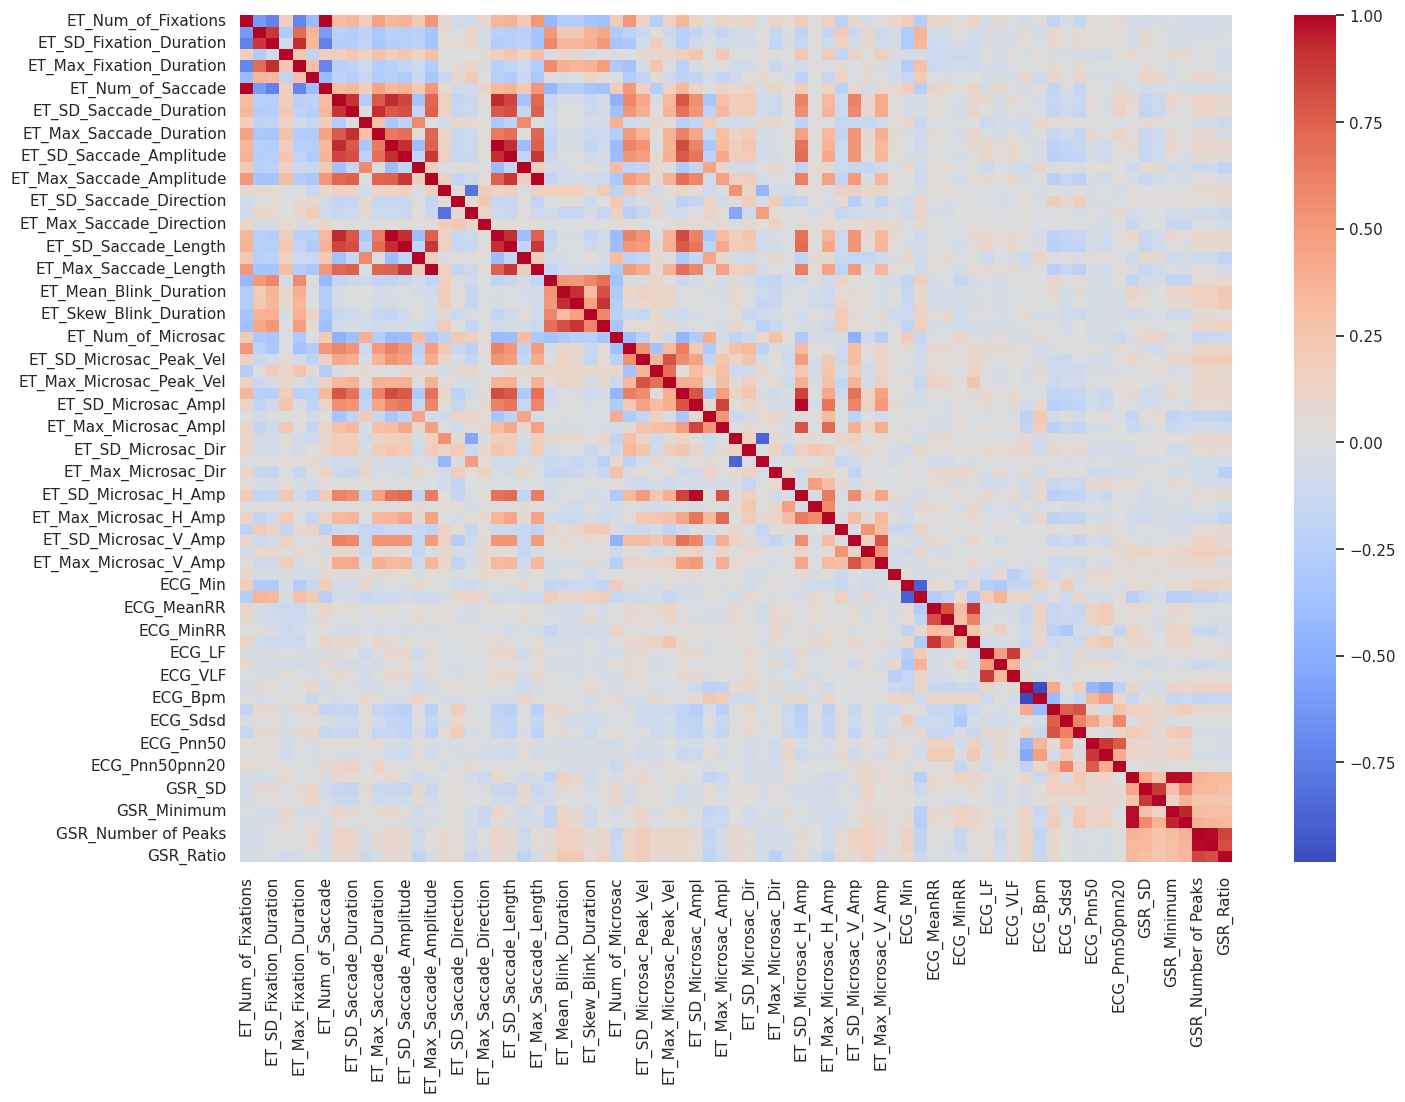

In [233]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(df_COMBINED.corr(), annot=False, cmap="coolwarm")

In [234]:
# We will drop features that have greater than 0.9 correlation but less than .99
corr = df_COMBINED.corr().abs()

visited = set()

columns = corr.columns
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        if corr.iloc[i][j] > 0.90 and corr.iloc[i][j] < .99:
            # print(columns[i], columns[j], corr.iloc[i][j])
            if columns[i] not in visited and columns[j] not in visited:
                visited.add(columns[i])
                print(corr.iloc[i][j])
print(len(columns), len(visited))
print(list(visited))

df_COMBINED.drop(list(visited), axis=1, inplace=True)


0.9185782023083288
0.9030443228580204
0.9206841501303367
0.9167471972640386
0.9167471972647742
0.9167471972607719
0.910455932595181
0.9054927129472033
0.9868107875527551
0.9837868123219832
0.9822552465935722
0.9433033108776308
0.9855029975746433
75 13
['ET_Mean_Saccade_Length', 'ECG_Ibi', 'GSR_Mean', 'ET_Mean_Saccade_Amplitude', 'GSR_Minimum', 'ET_Mean_Blink_Duration', 'GSR_Number of Peaks', 'ET_SD_Microsac_Ampl', 'ET_SD_Saccade_Duration', 'ET_SD_Blink_Duration', 'ET_SD_Saccade_Amplitude', 'ET_SD_Fixation_Duration', 'ET_Mean_Saccade_Duration']


<Axes: >

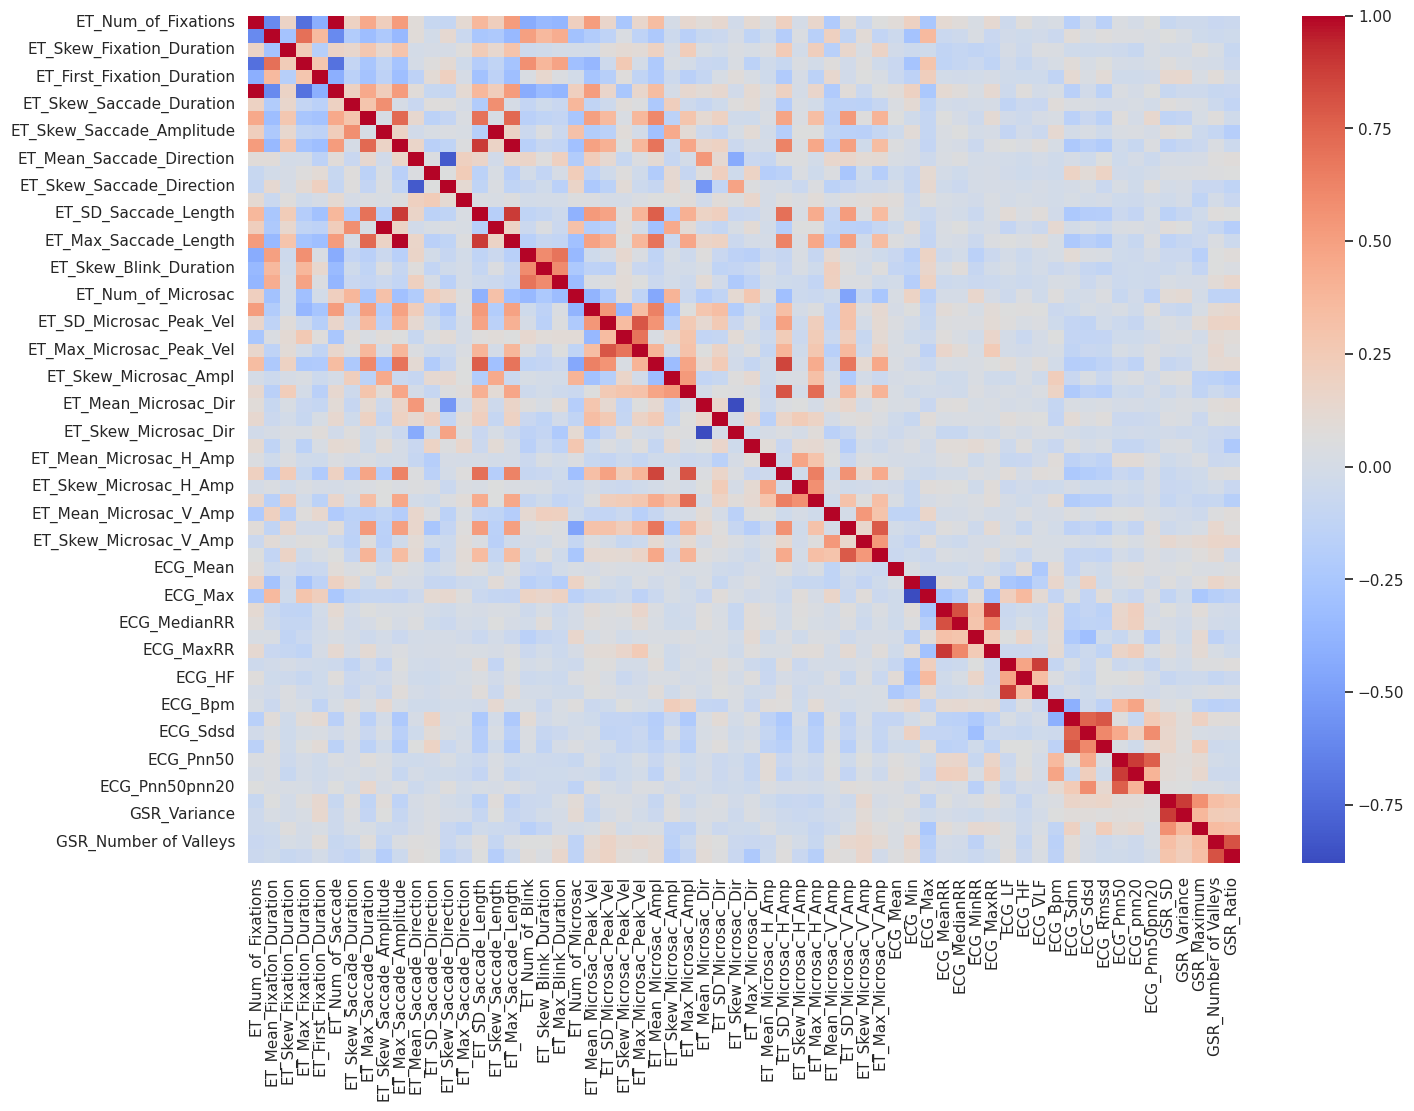

In [235]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(df_COMBINED.corr(), annot=False, cmap="coolwarm")

### Checking imbalance


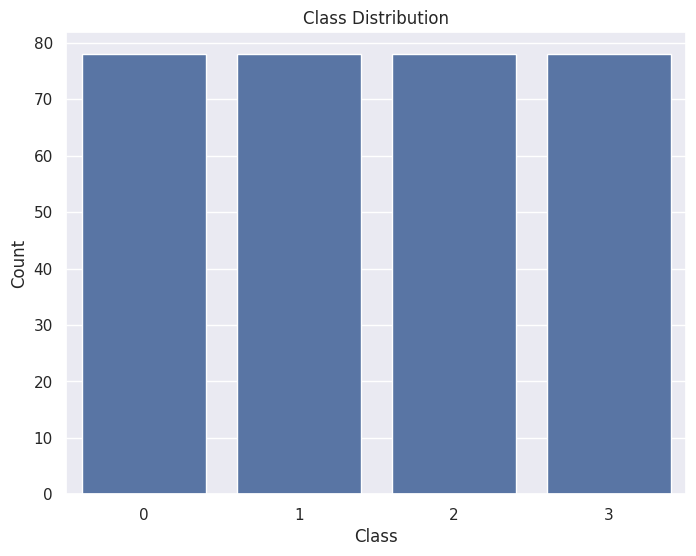

In [236]:
class_counts = labels.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

It seems that the data was curated to ensure even balance of the target class. There is no need for further cleaning.

### Data Cleaning and EDA Conclusion

lorem ipsum dolor

In [237]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train_COMBINED, X_test_COMBINED, y_train_COMBINED, y_test_COMBINED =  train_test_split(df_COMBINED, labels, test_size=0.1)

logreg = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.5, 0.9],
}

grid_logistic_COMBINED = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=0)

grid_logistic_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_logistic_COMBINED.best_params_
best_score = grid_logistic_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_logistic_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'C': 1, 'class_weight': None, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.6928571428571428
[1 3 3 0 1 1 3 2 0 2 0 2 2 2 1 1 1 0 1 3 0 1 0 2 2 3 1 3 0 0 1 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.65625


In [281]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [0, 5, 10, 20, 30, 40, 50],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid_knn_COMBINED = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_knn_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_knn_COMBINED.best_params_
best_score = grid_knn_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_knn_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.475
[3 1 3 1 1 1 2 2 1 2 1 2 2 2 2 1 1 2 1 2 0 2 2 1 2 2 1 0 2 0 1 1]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.5


In [238]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
grid_rf_COMBINED = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_rf_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_rf_COMBINED.best_params_
best_score = grid_rf_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_rf_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
0.7107142857142857
[0 3 3 0 1 1 3 3 2 2 3 2 0 2 2 1 1 0 2 0 0 2 0 1 0 3 1 3 3 0 1 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.65625


In [282]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': np.logspace(-10, 10, 11, base=2)
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))

grid_ada_COMBINED = GridSearchCV(ada, parameters, cv=10, scoring='accuracy', verbose=0)

grid_ada_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_ada_COMBINED.best_params_
best_score = grid_ada_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_ada_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'learning_rate': np.float64(1.0), 'n_estimators': 100}
0.5714285714285714
[0 0 3 0 1 1 3 3 1 2 3 2 0 2 2 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.625


In [239]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel':['linear', 'rbf'], 
              'C':np.logspace(-5, 5, 11, base=2),
              'gamma':np.logspace(-5, 5, 11, base=2)
             }
svc = SVC()
grid_svc_COMBINED = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')

grid_svc_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_svc_COMBINED.best_params_
best_score = grid_svc_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_svc_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'C': np.float64(4.0), 'gamma': np.float64(0.03125), 'kernel': 'linear'}
0.6500000000000001
[0 0 3 0 1 1 3 2 1 2 0 2 1 2 2 1 1 0 1 3 0 1 0 2 1 0 2 0 0 0 2 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.5625


In [283]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 60, 70, 80, 90, 100, 110],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier()

grid_dt_COMBINED = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)

grid_dt_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_dt_COMBINED.best_params_
best_score = grid_dt_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_dt_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'criterion': 'entropy', 'max_depth': 90, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 5, 'splitter': 'random'}
0.6249999999999999
[2 3 3 1 1 2 0 3 1 2 3 2 2 0 1 1 1 0 2 0 0 1 0 2 3 3 2 0 0 0 0 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.53125


In [313]:
# Ensemble Voting

from scipy import stats
prediction1 = grid_logistic_COMBINED.best_estimator_.predict(X_test_COMBINED)
prediction2 = grid_rf_COMBINED.best_estimator_.predict(X_test_COMBINED)
prediction3 = grid_knn_COMBINED.best_estimator_.predict(X_test_COMBINED)
prediction4 = grid_ada_COMBINED.best_estimator_.predict(X_test_COMBINED)
prediction5 = grid_svc_COMBINED.best_estimator_.predict(X_test_COMBINED)
prediction6 = grid_dt_COMBINED.best_estimator_.predict(X_test_COMBINED)

predictions = np.array([
    prediction1,
    prediction2,
    prediction3,
    prediction4,
    prediction5,
    prediction6
])
prediction = stats.mode(predictions, axis=0)[0]
print(prediction)

[0 3 3 0 1 1 3 2 1 2 3 2 2 2 2 1 1 0 1 0 0 1 0 1 0 3 1 0 0 0 1 2]


In [314]:
test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

[0 3 3 0 1 1 3 2 1 2 3 2 2 2 2 1 1 0 1 0 0 1 0 1 0 3 1 0 0 0 1 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.75


In [240]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

f_ET = [] 
f_ECG_GSR = []

for i in range(len(df_COMBINED.columns)):
    feature = df_COMBINED.columns[i]
    if feature[:3] == 'ET_':
        f_ET.append(feature)
    else:
        f_ECG_GSR.append(feature)
        
X_train_ET = X_train_COMBINED[f_ET]
X_test_ET = X_test_COMBINED[f_ET]
y_train_ET = y_train_COMBINED
y_test_ET = y_test_COMBINED

logreg = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0.1, 0.5, 0.9],
}

grid_logistic = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=1)

grid_logistic.fit(X_train_ET, y_train_ET)

best_params = grid_logistic.best_params_
best_score = grid_logistic.best_score_

print(best_params)
print(best_score)

prediction = grid_logistic.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits
{'C': 1, 'class_weight': None, 'l1_ratio': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.6214285714285713
[3 3 3 0 1 0 3 2 0 0 0 2 2 2 1 0 3 0 1 3 3 1 0 1 1 3 0 1 1 0 2 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.5


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [13, 15, 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [0, 5, 10, 20, 30, 40, 50],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_knn.fit(X_train_ET, y_train_ET)

best_params = grid_knn.best_params_
best_score = grid_knn.best_score_

print(best_params)
print(best_score)

prediction = grid_knn.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
0.4892857142857142
[2 0 1 0 1 1 2 1 2 0 3 3 0 0 2 1 3 1 0 1 2 0 1 0 1 2 1 1 0 2 1 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.5


In [245]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)
grid_rf.fit(X_train_ET, y_train_ET)

best_params = grid_rf.best_params_
best_score = grid_rf.best_score_

print(best_params)
print(best_score)

prediction = grid_rf.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
0.5750000000000001
[3 1 3 0 1 1 3 2 0 2 0 2 2 2 2 1 1 1 2 3 0 2 0 1 1 2 1 1 3 0 1 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.65625


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': np.logspace(-10, 10, 11, base=2)
}

ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1))

grid_ada = GridSearchCV(ada, parameters, cv=10, scoring='accuracy', verbose=0)

grid_ada.fit(X_train_ET, y_train_ET)

best_params = grid_ada.best_params_
best_score = grid_ada.best_score_

print(best_params)
print(best_score)

prediction = grid_ada.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'learning_rate': np.float64(0.015625), 'n_estimators': 300}
0.5214285714285715
[1 1 2 0 1 1 1 1 2 3 3 3 0 0 0 3 1 0 0 1 2 0 3 0 1 2 1 1 0 3 1 1]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.5625


In [241]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel':['linear', 'rbf'], 
              'C':np.logspace(-5, 5, 11, base=2),
              'gamma':np.logspace(-5, 5, 11, base=2)
             }
svc = SVC()
grid_svc = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')

grid_svc.fit(X_train_ET, y_train_ET)

best_params = grid_svc.best_params_
best_score = grid_svc.best_score_

print(best_params)
print(best_score)

prediction = grid_svc.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'C': np.float64(1.0), 'gamma': np.float64(0.03125), 'kernel': 'linear'}
0.5821428571428571
[3 3 3 0 1 3 3 3 0 2 0 2 2 2 1 0 3 0 1 3 3 1 0 2 2 3 0 1 1 0 2 2]
[3 3 3 0 2 2 3 2 1 2 3 2 2 2 2 2 1 0 2 3 0 1 0 1 0 2 1 3 0 0 1 2]
0.46875


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 60, 70, 80, 90, 100, 110],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier()

grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, n_jobs=-1, verbose=0)

grid_dt.fit(X_train_ET, y_train_ET)

best_params = grid_dt.best_params_
best_score = grid_dt.best_score_

print(best_params)
print(best_score)

prediction = grid_dt.best_estimator_.predict(X_test_ET)

test_labels = np.array(y_test_ET)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

{'criterion': 'entropy', 'max_depth': 110, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20, 'splitter': 'best'}
0.48571428571428577
[0 3 1 3 1 2 3 0 2 0 3 0 0 0 0 1 3 0 3 3 0 0 3 2 0 2 1 3 0 2 0 3]
[2 1 2 3 2 1 0 1 2 2 0 1 0 0 1 3 3 1 0 2 2 0 3 0 1 2 0 1 0 3 2 3]
0.3125


In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning

mlp = MLPClassifier(max_iter=1000, random_state=42, verbose=False)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],  
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate': ['constant', 'adaptive'],  
    'learning_rate_init': [0.001, 0.01, 0.1],  
    'batch_size': ['auto', 64, 128], 
}

grid_mlp_COMBINED = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=0)

grid_mlp_COMBINED.fit(X_train_COMBINED, y_train_COMBINED)

best_params = grid_mlp_COMBINED.best_params_
best_score = grid_mlp_COMBINED.best_score_

print(best_params)
print(best_score)

prediction = grid_mlp_COMBINED.best_estimator_.predict(X_test_COMBINED)

test_labels = np.array(y_test_COMBINED)
print(prediction)
print(test_labels)

total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

In [ ]:
# TODO: accuracy, precision, recall, AUC curve

### References
[1] Luma Tabbaa, Ryan Searle, Saber Mirzaee Bafti, Md Moinul Hossain, Jittrapol Intarasisrisawat, Maxine Glancy, and Chee Siang Ang. 2022. VREED: Virtual Reality Emotion Recognition Dataset Using Eye Tracking & Physiological Measures. Proc. ACM Interact. Mob. Wearable Ubiquitous Technol. 5, 4, Article 178 (Dec 2021), 20 pages. https://doi.org/10.1145/3495002

